In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
# data_dir="/Volumes/LaCie/may31/savepred5"
data_dir="/Volumes/LaCie/may31/savepred3"
img_dir=os.path.join(data_dir, "original")
gt_dir=os.path.join(data_dir, "ground_truth")
pred_dir=os.path.join(data_dir, "pred")

(3, 512, 512) (3, 512, 512) (3, 512, 512)


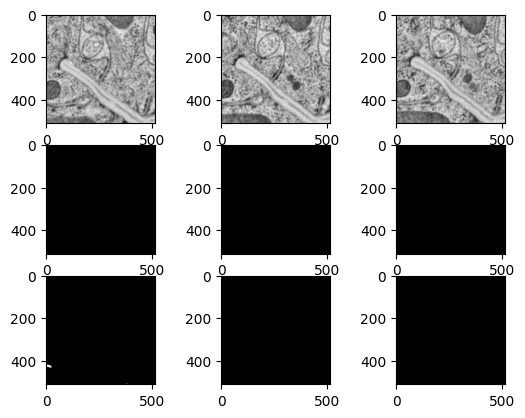

In [15]:
# 8144
# 9168
dim=512
z,y,x = 0,4096,4096
suffix = r"z{}_y{}_x{}".format(z, y, x)
img_vol = np.load(os.path.join(img_dir, f"{suffix}.npy"))
gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
pred_vol = np.load(os.path.join(pred_dir, f"{suffix}.npy"))
pred_vol = np.argmax(pred_vol[0], 0) 
print(img_vol.shape, gt_vol.shape, pred_vol.shape)
depth = pred_vol.shape[0]
fig, ax = plt.subplots(3,depth)
visualize_3d_slice(img_vol, ax[0])
visualize_3d_slice(gt_vol, ax[1])
visualize_3d_slice(pred_vol, ax[2])

(512, 512, 3)


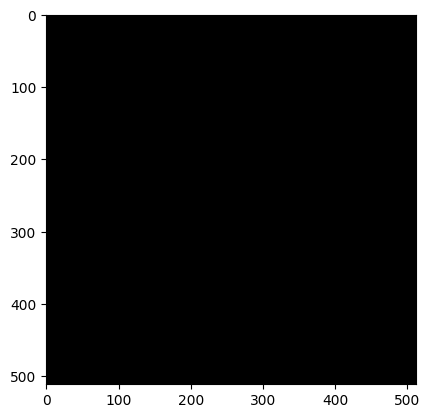

In [16]:
colored_gt = np.stack((gt_vol[0],)*3, axis=-1)
print(colored_gt.shape)
plt.imshow(colored_gt)

In [17]:
tile_depth, tile_width, tile_height = 3, 512, 512

In [18]:
import copy
import tqdm
import torchio as tio
def assemble_predictions(images_dir, preds_dir, gt_dir, overlay=True):
    # superimpose the predictions on the image 
    red = (0, 0, 255) # FP
    green = (0, 255, 0) #TP
    blue = (255, 0, 0) #FN

    preds_colors = [green, red, blue]

    # magenta:
    # magenta = (255, 0, 255) #conf 5
    # cyan = (255, 255, 0) #conf 4
    # brown = (0, 255, 255) #conf 3
    # orange = (0, 165, 255) #conf 2
    # light_blue = (255, 165, 0) #conf 1
    conf5 = (255, 0, 255) #conf 5
    conf4 = (255, 255, 0) #conf 4
    conf3 = (0, 255, 255) #conf 3
    conf2 = (0, 165, 255) #conf 2
    conf1 = (255, 165, 0) #conf 1

    gt_colors = [conf1, conf2, conf3, conf4, conf5]
    end_s = 6
    end_y = 8192
    end_x = 9216
    start_y=0
    start_x=0
    total_slices = ((end_s//3) * ((end_y-start_y)//512 )* ((end_x-start_x)//512))
    slice_num = 0
    print(total_slices, "total slices")
    for s in range(0, end_s, 3):
        s_acc_img, s_acc_pred, s_acc_gt = [], [], []
        for y in range(start_y, end_y, 512):
            y_acc_img, y_acc_pred, y_acc_gt = [], [], []
            for x in range(start_x, end_x, 512):
                print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}", end="\r")
                suffix = r"z{}_y{}_x{}".format(s, y, x)
                
                # load img
                try:
                    img_vol = np.load(os.path.join(images_dir, f"{suffix}.npy"))
                except:
                    img_vol = np.zeros((3, 512,512))
                    print("no img")
                d, h, w = img_vol.shape
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    print("cropping since imgvol shape:", img_vol.shape)
                    img_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(torch.tensor(img_vol).unsqueeze(0))
                
                # load gt
                try:
                    gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
                except:
                    gt_vol = np.zeros((3,512,512))
                    print("no gt")
                if (d < tile_depth) or (h < tile_height) or (w< tile_width):
                    gt_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(gt_vol)
                
                # load pred
                try:
                    pred_vol = np.load(os.path.join(preds_dir, f"{suffix}.npy"))
                    pred_vol = np.argmax(pred_vol[0], 0) 
                except:
                    print("no pred vol")
                    pred_vol = np.zeros((3, 512,512))
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    pred_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(pred_vol)
                    
                small_3d_img = []
                small_3d_pred = []
                small_3d_gt = []
                for k in range(3):
                    img = img_vol[k]
                    gt = gt_vol[k]
                    pred = pred_vol[k]
                    small_3d_img += [img]
                    small_3d_gt += [gt]
                    small_3d_pred += [pred]
                    
                small_3d_pred = np.array(small_3d_pred)
                small_3d_gt = np.array(small_3d_gt)
                small_3d_img = np.array(small_3d_img)
                    
                y_acc_gt += [small_3d_gt]
                y_acc_img += [small_3d_img]
                y_acc_pred += [small_3d_pred]
                slice_num+=1
            print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}")
            s_acc_img += [np.concatenate(y_acc_img, axis=2)]
            s_acc_pred += [np.concatenate(y_acc_pred, axis=2)]
            s_acc_gt += [np.concatenate(y_acc_gt, axis=2)]

        new_img = np.concatenate(s_acc_img, axis=1)
        new_pred = np.concatenate(s_acc_pred, axis=1)
        new_gt = np.concatenate(s_acc_gt, axis=1)
        
        return new_img, new_pred, new_gt

In [19]:
from tqdm import tqdm 
new_img, new_pred, new_gt = assemble_predictions(img_dir, pred_dir, gt_dir)
print("shape", new_img.shape, new_pred.shape, new_gt.shape)

576 total slices
Processing volume (0, 0, 8704) | Progress:19/576 0.031253888888888888
Processing volume (0, 512, 8704) | Progress:37/576 0.062563888888888896
Processing volume (0, 1024, 8704) | Progress:55/576 0.09375388888888898
Processing volume (0, 1536, 8704) | Progress:73/576 0.12526388888888898
Processing volume (0, 2048, 8704) | Progress:91/576 0.15625388888888896
Processing volume (0, 2560, 8704) | Progress:109/576 0.18756388888888896
Processing volume (0, 3072, 8704) | Progress:127/576 0.21875388888888896
Processing volume (0, 3584, 8704) | Progress:145/576 0.25826388888888896
Processing volume (0, 4096, 8704) | Progress:163/576 0.2812538888888889
Processing volume (0, 4608, 8704) | Progress:181/576 0.3125638888888889
no imgsing volume (0, 5120, 0) | Progress:181/576 0.3125
no gt
no pred vol
no imgsing volume (0, 5120, 512) | Progress:182/576 0.3142361111111111
no gt
no pred vol
no imgsing volume (0, 5120, 1024) | Progress:183/576 0.3159722222222222
no gt
no pred vol
no imgsi

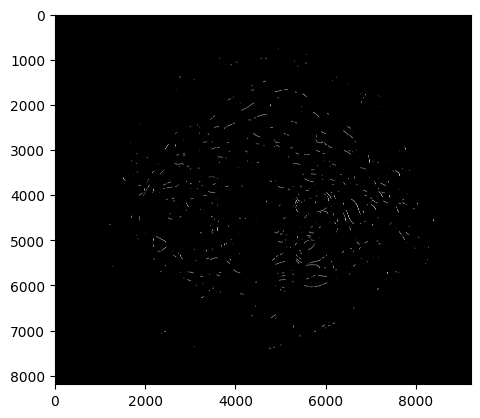

In [8]:
plt.imshow(new_pred[0], cmap="gray")

In [20]:
binary_gt = new_gt.copy()
binary_gt[binary_gt != 0] = 1
print(np.unique(binary_gt, return_counts=True))

(array([0., 1.]), array([225648366,    844050]))


In [22]:
# save separate
save_dir = "/Volumes/LaCie/gapjnc92/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
print(new_img.shape, new_pred.shape, new_gt.shape)
for k in range(6):
    cv2.imwrite(save_dir + suffix + f"_img_slice{k}.png", new_img[k])
    plt.imsave(save_dir + suffix + f"_pred_slice{k}.png", new_pred[k], cmap="gray")
    plt.imsave(save_dir + suffix + f"_gt_slice{k}.png", new_gt[k], cmap="gray")
    print(f"Saved slice {k}")

(3, 8192, 9216) (3, 8192, 9216) (3, 8192, 9216)
Saved slice 0
Saved slice 1
Saved slice 2


IndexError: index 3 is out of bounds for axis 0 with size 3

In [26]:
def get_colored_image(image, color_map=None):
    # Define the default color map
    if color_map is None:
        color_map = {
            0: [0, 0, 0],  # Black (TN)
            1: [1, 0, 0],  # Red (FP) (pred only)
            2: [0, 0, 1],  # Blue (FN) (double_mask only)
            3: [0, 1, 0],  # Green (TP)
        }
    # Create an empty RGB image
    depth, height, width = image.shape[0], image.shape[1], image.shape[2]
    colored_image = np.zeros((depth, height, width, 3), dtype=np.float32) 
    
    # Map the pixel values to the corresponding colors
    for value, color in color_map.items():
        colored_image[image == value] = color
    return colored_image

In [27]:
combined_volume = np.asarray((binary_gt[1] * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
print(np.unique(combined_volume, return_counts=True))

(array([0., 1., 2., 3.]), array([225387173,    256744,    657195,    191304]))


In [25]:
# save separate
save_dir = "/Volumes/LaCie/gapjnc92/combined_two"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for k in range(3):
    plt.imsave(save_dir + suffix + f"_comb_slice{k}.png", color_combined_volume[k], cmap="gray")
    print(f"Saved slice {k}")

Saved slice 0
Saved slice 1
Saved slice 2


IndexError: index 3 is out of bounds for axis 0 with size 3

In [12]:
color_combined_volume.shape

(3, 8192, 9216, 3)

In [13]:
# save combined
save_dir = "/Volumes/LaCie/gapjnc92/combined_two/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
use_lines = False
alpha = 0.4
yellow = [255, 255, 0]
line_width = 3
height, width = new_img.shape[1], new_img.shape[2]
for k in range(3):
    print(f"Saved {k}")
    fig = plt.figure(num=1)
    if use_lines:
        lined_img = new_img[k].copy()
        lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
        lined_img = np.stack((lined_img,) * 3, axis=-1)

        for y in range(0, height, 512):
            lined_img[y:y+line_width, :] = yellow
        for x in range(0, width, 512):
            lined_img[:, x:x+line_width] = yellow
        plt.imshow(lined_img)
    else:
        plt.imshow(new_img[k], cmap='gray')
    plt.imshow(color_combined_volume[k], alpha=alpha)
    plt.savefig(save_dir + f"tmp{k}.png", dpi=800)
    plt.close("all")

Saved 0
Saved 1
Saved 2


In [34]:
# save combined
save_dir = "/Volumes/LaCie/gapjnc16/combined/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
use_lines = True
alpha = 0.4
yellow = [255, 255, 0]
line_width = 3
height, width = new_img.shape[1], new_img.shape[2]
for k in range(3):
    print(f"Saved {k}")
    fig = plt.figure(num=1)
    if use_lines:
        lined_img = new_img[k].copy()
        lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
        lined_img = np.stack((lined_img,) * 3, axis=-1)

        for y in range(0, height, 512):
            lined_img[y:y+line_width, :] = yellow
        for x in range(0, width, 512):
            lined_img[:, x:x+line_width] = yellow
        plt.imshow(lined_img)
    else:
        plt.imshow(new_img[k], cmap='gray')
    plt.imshow(color_combined_volume[k], alpha=alpha)
    plt.savefig(save_dir + f"tmp{k}.png", dpi=800)
    plt.close("all")

Saved 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


: 